<a href="https://colab.research.google.com/github/sushi15/Fashion-MNIST/blob/main/custom_architecture_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import itertools
import os

import matplotlib.pylab as plt 
from matplotlib import pyplot
import numpy as np 

import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint 

import keras 
from keras.applications.vgg19 import preprocess_input 
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers 
from tensorflow.python.keras.layers import Dense, Flatten, MaxPooling2D 
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Conv2D, InputLayer
from tensorflow.keras.losses import CategoricalCrossentropy

import random


from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
BATCH_SIZE = 128 #@param {type:"slider", min:0, max:256, step:2}

In [ ]:
EPOCH_SIZE = 25 #@param {type:"integer"}

# Load Fashion MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

0


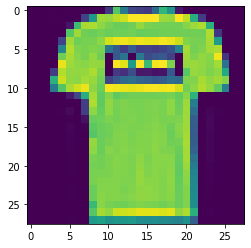

In [ ]:
plt.imshow(x_train[1]) 
print(y_train[1])

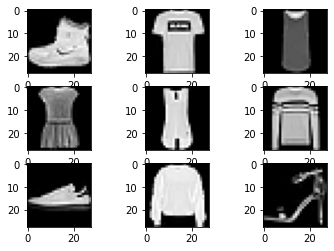

In [ ]:
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# Data Preprocessing

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) 
print(x_train.shape) 
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Rescale values to range [0, 1]

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

Reshape labels first to (n, 1) i.e. 1D to 2D then preprocess labels using one-hot encoding

In [ ]:
y_train = y_train.reshape(60000, 1) 
y_test = y_test.reshape(10000, 1)
# print(y_test.shape) 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train[50000:50010, :] #Some y_train values before split that should be the same as the first 10 y_val values

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Split training sets into training and validation sets

In [ ]:
training_set_size = 48000 #@param {type:"slider", min:0, max:60000, step:1000}
x_val = x_train[training_set_size:, :]
x_train = x_train[:training_set_size, :] 
y_val = y_train[training_set_size:, :] 
y_train = y_train[:training_set_size, :] 

print(x_val.shape) 
print(x_train.shape)
print(y_val.shape) 
print(y_train.shape)

(12000, 28, 28, 1)
(48000, 28, 28, 1)
(12000, 10)
(48000, 10)


In [ ]:
y_val[:10, :] #Test y_val values after split

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Data Augmentation

In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

# Defining the Model

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape = (28, 28, 1), name = 'conv2d_3_input'))
model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (28, 28, 1), name = 'conv2d_3'))
model.add(MaxPooling2D(pool_size = (2, 2), name = 'max_pooling_2d_2'))
model.add(Conv2D(64, (3, 3), activation = 'relu', name = 'conv2d_4'))
model.add(MaxPooling2D(pool_size = (2, 2), name = 'max_pooling_2d_3'))

model.add(Flatten(name = 'flatten'))
model.add(Dense(256, activation = 'relu', name = 'dense'))
model.add(Dense(10, activation = 'softmax', name = 'dense_1')) 

Model Architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling_2d_2 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling_2d_3 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               409856    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Checkpoints

In [ ]:
checkpoint_path = '/content/gdrive/My Drive/CNNs/custom/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    period = 1) 

For reloading

In [ ]:
# model.load_weights('/content/gdrive/My Drive/CNNs/custom/cp-0004.ckpt') 

# Training

In [ ]:
history=model.fit(gen.flow(x_train, y_train, BATCH_SIZE), 
                  steps_per_epoch = y_train.shape[0] // BATCH_SIZE, 
                  epochs = EPOCH_SIZE, 
                  validation_data = gen.flow(x_val, y_val, BATCH_SIZE),
                  validation_steps = y_val.shape[0] // BATCH_SIZE,
                  callbacks = [cp_callback]
                    )

Epoch 1/25
375/375 [==============================] - 79s 208ms/step - loss: 0.6864 - accuracy: 0.7457 - val_loss: 0.5186 - val_accuracy: 0.8030

Epoch 00001: saving model to /content/gdrive/My Drive/CNNs/custom/cp-0001.ckpt
Epoch 2/25
375/375 [==============================] - 78s 207ms/step - loss: 0.4832 - accuracy: 0.8180 - val_loss: 0.4459 - val_accuracy: 0.8339

Epoch 00002: saving model to /content/gdrive/My Drive/CNNs/custom/cp-0002.ckpt
Epoch 3/25
375/375 [==============================] - ETA: 0s - loss: 0.4269 - accuracy: 0.8412
Epoch 00003: saving model to /content/gdrive/My Drive/CNNs/custom/cp-0003.ckpt
Epoch 4/25
375/375 [==============================] - 77s 205ms/step - loss: 0.3885 - accuracy: 0.8531 - val_loss: 0.3775 - val_accuracy: 0.8569

Epoch 00004: saving model to /content/gdrive/My Drive/CNNs/custom/cp-0004.ckpt
Epoch 5/25
375/375 [==============================] - 77s 206ms/step - loss: 0.3669 - accuracy: 0.8621 - val_loss: 0.3590 - val_accuracy: 0.8638

Epoc

# Analaysis

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Plots

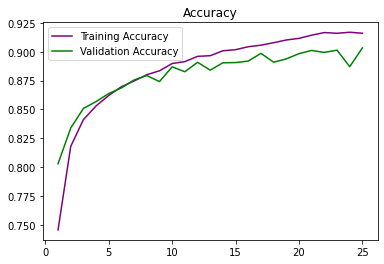

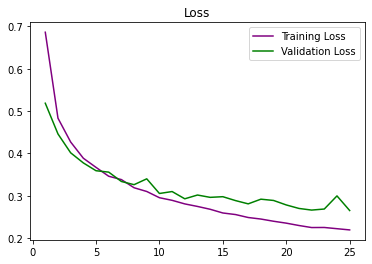

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Accuracy')
plt.plot(epochs, acc, 'purple', label='Training Accuracy')
plt.plot(epochs, val_acc, 'green', label = 'Validation Accuracy')
plt.legend()

plt.figure()
plt.title('Loss')
plt.plot(epochs, loss, 'purple', label = 'Training Loss')
plt.plot(epochs, val_loss, 'green', label = 'Validation Loss')

plt.legend()

plt.show()

Running on test sets

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Loss on running test : ', score[0])
print('Accuracy on running test : ', score[1]) 

Loss on running test :  0.2501012086868286
Accuracy on running test :  0.9158999919891357


In [ ]:
# x_train.shape[0], BATCH_SIZE, EPOCH_SIZE -> Test set accuracy 
# 50000, 128, 10 -> 0.899
# 50000, 64, 10 -> 0.899
# 50000, 64, 25 -> 0.915 
# 50000, 128, 25 -> 0.916